In [36]:
# import dependencies
import tweepy
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
plt.style.use('seaborn')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (twt_consumer_key, 
                    twt_consumer_secret, 
                    twt_access_token, 
                    twt_access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(twt_consumer_key, twt_consumer_secret)
auth.set_access_token(twt_access_token, twt_access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [37]:
def get_sentiments(handle, pages):

    tweet_text_list = []
    date_list = []
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    handle_list = []
    full_results = {}

    for i in range(pages):
        all_tweets = api.user_timeline(handle, page=i)
        for tweet in all_tweets:
            tweet_text = tweet["text"]
            raw_time = tweet["created_at"]
            time_object = time.strptime(raw_time, "%a %b %d %H:%M:%S %z %Y")
            tweet_date = time.strftime("%m/%d/%Y", time_object)
            sentiment = analyzer.polarity_scores(tweet_text)
            compound_list.append(sentiment["compound"])            
            positive_list.append(sentiment["pos"]) 
            negative_list.append(sentiment["neg"]) 
            neutral_list.append(sentiment["neu"]) 
            tweet_text_list.append(tweet_text)
            date_list.append(tweet_date)
            handle_list.append(handle)
    
    full_results = pd.DataFrame({
        "Account":handle_list,
        "Date":date_list,
        "Tweet Text":tweet_text_list,
        "Compound Score":compound_list,
        "Positive Score":positive_list,
        "Negative Score":negative_list,
        "Neutral Score":neutral_list
    })
    
    return full_results

In [50]:
outlets = ["@BBCNews","@CBSNews","@CNN","@FoxNews","@nytimes"]

tweets_and_sentiment_dict = {
    "Account":[],
    "Date":[],
    "Tweet Text":[],
    "Compound Score":[],
    "Positive Score":[],
    "Negative Score":[],
    "Neutral Score":[]
}
tweets_and_sentiment = pd.DataFrame(tweets_and_sentiment_dict)
compounds = []
avg_sentiments = []

for outlet in outlets:
    results = get_sentiments(outlet, 5)
    tweets_and_sentiment = tweets_and_sentiment.append(results, ignore_index=True)
    compounds.append(results["Compound Score"])
    avg_sentiment = np.mean(results["Compound Score"])
    avg_sentiments.append(avg_sentiment)    

In [51]:
tweets_and_sentiment.to_csv("tweets_and_sentiments.csv")

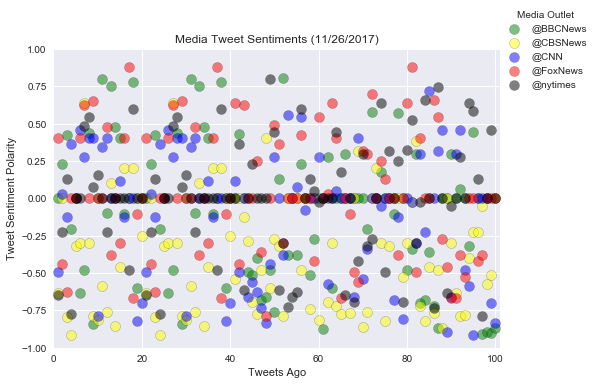

In [53]:
tweets_ago = range(1, len(compounds[0])+1)
colors = ["green","yellow","blue","red","black"]

for i in range(len(outlets)):
    plt.scatter(tweets_ago,compounds[i], c=colors[i], alpha=0.5, edgecolor="black", s=100)

current_time = time.localtime(time.time())
date = time.strftime("%m/%d/%Y", current_time)
    
plt.title(f"Media Tweet Sentiments ({date})")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Sentiment Polarity")
plt.ylim(-1,1)
plt.xlim(0, 101)
plt.legend(outlets, title="Media Outlet", loc=(1,0.85))    
plt.show()

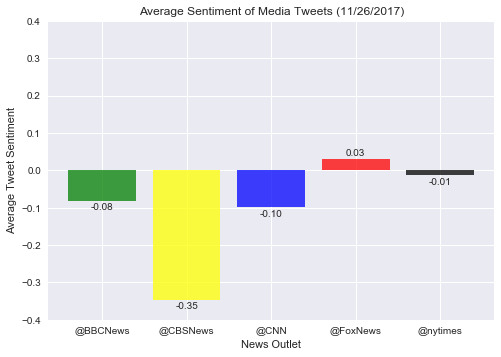

In [54]:
tick_locations = range(len(outlets))
plt.bar(tick_locations, avg_sentiments, color=colors, alpha=0.75)
plt.title(f"Average Sentiment of Media Tweets ({date})")
plt.xlabel("News Outlet")
plt.ylabel("Average Tweet Sentiment")
plt.xticks(tick_locations, outlets)
plt.ylim(-0.4,0.4)
for i in range(len(outlets)):
    if avg_sentiments[i] > 0:
        plt.text(tick_locations[i],avg_sentiments[i] + 0.01,"{0:.2f}".format(avg_sentiments[i]), ha="center")
    else:
        plt.text(tick_locations[i],avg_sentiments[i] - 0.025,"{0:.2f}".format(avg_sentiments[i]), ha="center")

plt.show()